# Explaining brain stroke model with Permutation-based Variable Importance

## 0. For the selected data set, train at least one tree-based ensemble model, e.g. random forest, gbdt, xgboost.

In [23]:
import pandas as pd
from sklearn.preprocessing import minmax_scale, OrdinalEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

df = pd.read_csv("brain_stroke.csv")

enc = OrdinalEncoder()
df[["Residence_type", "ever_married", "gender"]] = enc.fit_transform(df[["Residence_type", "ever_married", "gender"]])
df = pd.get_dummies(df, columns=["work_type"])
df = df.drop(columns=["smoking_status"])
df[['age','avg_glucose_level','bmi']] = minmax_scale(df[['age','avg_glucose_level','bmi']])

X = df.drop("stroke", axis=1)
y = df["stroke"]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=5)

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=4, random_state=0)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, random_state=0)

## 1. Calculate Permutation-based Variable Importance for the selected model.

In [24]:
import dalex as dx
rfc_exp = dx.Explainer(rfc, X_test, y_test, verbose=False)
rfc_pvi = rfc_exp.model_parts(random_state=0)
print(rfc_pvi.result)
rfc_pvi.plot(show=False).update_layout(autosize=False, width=600, height=450)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


                   variable  dropout_loss                   label
0         work_type_Private      0.181777  RandomForestClassifier
1              _full_model_      0.181791  RandomForestClassifier
2                    gender      0.181959  RandomForestClassifier
3            Residence_type      0.182133  RandomForestClassifier
4        work_type_Govt_job      0.182503  RandomForestClassifier
5              hypertension      0.182935  RandomForestClassifier
6        work_type_children      0.184150  RandomForestClassifier
7   work_type_Self-employed      0.184251  RandomForestClassifier
8             heart_disease      0.184314  RandomForestClassifier
9                       bmi      0.186408  RandomForestClassifier
10             ever_married      0.195019  RandomForestClassifier
11        avg_glucose_level      0.196972  RandomForestClassifier
12                      age      0.370212  RandomForestClassifier
13               _baseline_      0.495193  RandomForestClassifier


![](1.png)

As in many previous analyses, the age of the person turned out to be the most important. Glucose levels and marital status turn out to be equally important.

## 2. Train three more candidate models (different variable transformations, different model architectures, hyperparameters) and compare their rankings of important features using PVI. What are the differences? Why?

In [33]:
from sklearn.linear_model import LogisticRegression
print("Logistic regression")
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_exp = dx.Explainer(lr, X_test, y_test, verbose=False)
lr_pvi = lr_exp.model_parts(random_state=0)
lr_pvi.plot(show=False).update_layout(autosize=False, width=600, height=450)

Logistic regression


X does not have valid feature names, but LogisticRegression was fitted with feature names


![](2.png)

In [34]:
print("Deeper random forest classifier")
deeper_rfc = RandomForestClassifier(max_depth=8, random_state=0)
deeper_rfc.fit(X_train, y_train)
deeper_rfc_exp = dx.Explainer(deeper_rfc, X_test, y_test, verbose=False)
deeper_rfc_pvi = deeper_rfc_exp.model_parts(random_state=0)
print(deeper_rfc_pvi.result)
deeper_rfc_pvi.plot(show=False).update_layout(autosize=False, width=600, height=450)

Deeper random forest classifier


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


                   variable  dropout_loss                   label
0        work_type_Govt_job      0.185325  RandomForestClassifier
1              _full_model_      0.186519  RandomForestClassifier
2              hypertension      0.187094  RandomForestClassifier
3   work_type_Self-employed      0.187220  RandomForestClassifier
4                    gender      0.187820  RandomForestClassifier
5             heart_disease      0.188044  RandomForestClassifier
6         work_type_Private      0.188850  RandomForestClassifier
7            Residence_type      0.188863  RandomForestClassifier
8                       bmi      0.193384  RandomForestClassifier
9              ever_married      0.194995  RandomForestClassifier
10        avg_glucose_level      0.196629  RandomForestClassifier
11       work_type_children      0.197265  RandomForestClassifier
12                      age      0.405204  RandomForestClassifier
13               _baseline_      0.490978  RandomForestClassifier


![](3.png)

In [35]:
import xgboost

print("XGBClassifier")
xgbc = xgboost.XGBClassifier(
    n_estimators=50,
    max_depth=2,
    use_label_encoder=False,
    eval_metric="logloss",

    enable_categorical=True,
    tree_method="hist"
)
xgbc.fit(X_train, y_train)
xgbc_exp = dx.Explainer(xgbc, X_test, y_test, verbose=False)
xgbc_pvi = xgbc_exp.model_parts(random_state=0)
print(xgbc_pvi.result)
xgbc_pvi.plot(show=False).update_layout(autosize=False, width=600, height=450)

XGBClassifier
                   variable  dropout_loss          label
0        work_type_Govt_job      0.189052  XGBClassifier
1             heart_disease      0.189643  XGBClassifier
2              _full_model_      0.190035  XGBClassifier
3              hypertension      0.190035  XGBClassifier
4        work_type_children      0.190035  XGBClassifier
5   work_type_Self-employed      0.190443  XGBClassifier
6              ever_married      0.191685  XGBClassifier
7            Residence_type      0.192445  XGBClassifier
8                    gender      0.194239  XGBClassifier
9         work_type_Private      0.194798  XGBClassifier
10                      bmi      0.200371  XGBClassifier
11        avg_glucose_level      0.206179  XGBClassifier
12                      age      0.433005  XGBClassifier
13               _baseline_      0.494119  XGBClassifier


![](4.png)

All models consider age as the most important characteristic, but they give it different weights. A deeper randomforest assigns more weight to age than a shallower one, because perhaps by using more branches it is better able to match the age-based training set. The linear regression model differs significantly in the case of non-age features from the other models that rely on branching. The linear regression model gives great importance to features related to the type of work performed, interestingly, each of these types is very important. This may be due to the fact that the data was characterized by the fact that each person performed one type of work, while after permuting a given feature to calculate pvi, this rule was broken, which could have a bad effect on the linear regression model. At the same time, tree models may not have noticed it by sifting out the types of work. xgbclassifier noticed the importance of the bmi factor, while other models did not pay attention to it. Indeed, each model pays attention to slightly different properties of the data.

## 3. For the tree-based model from (1), compare PVI with:

### A) the traditional feature importance measures for trees: Gini impurity etc.; what is implemented in a given library: see e.g. the feature_importances_ attribute in xgboost and sklearn.

In [28]:
print(rfc_pvi.result)
rfc_pvi.plot(show=False).update_layout(autosize=False, width=600, height=450)

                   variable  dropout_loss                   label
0         work_type_Private      0.181777  RandomForestClassifier
1              _full_model_      0.181791  RandomForestClassifier
2                    gender      0.181959  RandomForestClassifier
3            Residence_type      0.182133  RandomForestClassifier
4        work_type_Govt_job      0.182503  RandomForestClassifier
5              hypertension      0.182935  RandomForestClassifier
6        work_type_children      0.184150  RandomForestClassifier
7   work_type_Self-employed      0.184251  RandomForestClassifier
8             heart_disease      0.184314  RandomForestClassifier
9                       bmi      0.186408  RandomForestClassifier
10             ever_married      0.195019  RandomForestClassifier
11        avg_glucose_level      0.196972  RandomForestClassifier
12                      age      0.370212  RandomForestClassifier
13               _baseline_      0.495193  RandomForestClassifier


![](1.png)

                   variable  importance
1                       age    0.567259
4              ever_married    0.166746
7                       bmi    0.086340
6         avg_glucose_level    0.078196
11       work_type_children    0.044619
2              hypertension    0.014749
3             heart_disease    0.013817
10  work_type_Self-employed    0.012046
0                    gender    0.005059
9         work_type_Private    0.004609
5            Residence_type    0.003555
8        work_type_Govt_job    0.003006


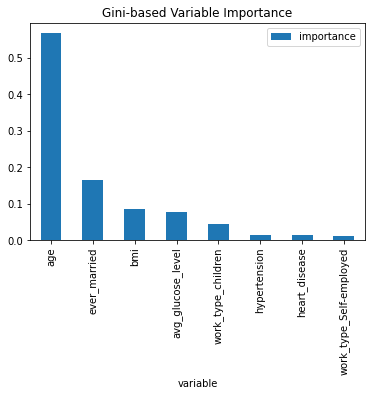

In [29]:
df = pd.DataFrame({'variable': X_test.columns, 'importance': rfc.feature_importances_}).sort_values(by='importance', ascending=False)
print(df)
import matplotlib.pyplot as plt
df.head(8).plot.bar(x='variable', y='importance')
plt.title("Gini-based Variable Importance")
plt.show()


As in the pvi analysis, in gini analysis age turned out to be the most important, while marital status, glucose level and bmi are at a similar level. It seems that such a result is better because it emphasizes the importance of the bmi index, which was omitted in the randomforest pvi analysis, while for xgboost it turned out to be important.

### B) [in Python] SHAP variable importance based on the TreeSHAP algorithm available in the shap package.

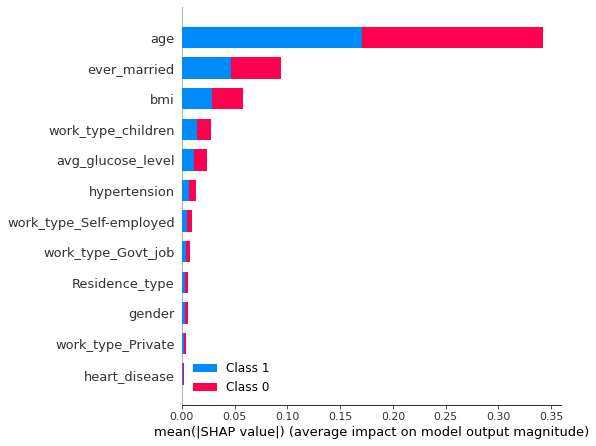

In [30]:
shap_vi = rfc_exp.model_parts(type="shap_wrapper", shap_explainer_type="TreeExplainer")
shap_vi.plot()

As in every previous case, age is the most important in SHAP variable importance, similarly as in random forest, marital status is important, but also bmi turned out to be important. Each technique yielded slightly different results that better sift out the really important data properties.